In [10]:
import warnings
warnings.filterwarnings("ignore")

import os
import re
import sys
import time
import json
import numpy as np
import pandas as pd
import geopandas as gpd
import pickle as pkl
import networkx as nx
import matplotlib.pyplot as plt

import statsmodels.api as sm
import statsmodels.formula.api as smf

from pprint import pprint

import src
from src.reload import deep_reload

In [11]:
directory = 'Outputs/Random_Experiment/'

files = os.listdir(directory)

In [12]:
graph = src.graph.graph_from_json('Outputs/graph_empty.json')

places = src.graph.graph_from_json('Outputs/places.json')

pop_adj = sum([v['population'] for k, v in places._node.items()]) / len(places)

weighted = {k: v['population'] / pop_adj for k, v in places._node.items()}

unweighted = {k: 1 for k, v in places._node.items()}

In [186]:
deep_reload(src)

specific_impedance = lambda x, k: src.routing.impedance(
    x[4],
    origins = {k: 1},
    destinations = weighted,
    field = 'total_time',
    constant = 1 / 3600,
)

functions = {
    'capacity': lambda x: x[1]['capacity'] / 3.6e6,
    'power': lambda x: x[1]['power'] / 1e3,
    'risk_attitude': lambda x: (x[1]['risk_attitude'][0] + x[1]['risk_attitude'][1]) / 2,
    'reliability': lambda x: x[2]['station']['reliability'],
    'graph_index': lambda x: x[0],
    'impedance_w': lambda x: src.routing.impedance(
        x[4], origins = weighted, destinations = weighted, field = 'total_time',
    ) / 3600,
    'impedance_w_r': lambda x: src.routing.impedance(
        x[4], origins = weighted, destinations = weighted, field = 'routing_time',
    ) / 3600,
    'impedance_w_d': lambda x: src.routing.impedance(
        x[4], origins = weighted, destinations = weighted, field = 'driving_time',
    ) / 3600,
}

def itemized_impedance(values, origins, destinations):

    out = {}

    for k, v in values.items():

        out[k] = src.routing.specific_impedance(
            v, destinations, field = 'total_time',
        ) / 3600,

    return out

In [187]:
paths = {}

outputs = {k: [] for k in functions.keys()}

specific_outputs = []

idx = -1

success = []

for file in src.progress_bar.ProgressBar(files):

    idx += 1

    run = eval(re.findall(r'\d+', file)[0])

    if run < 9000:

        continue

    with open(directory + file, 'rb') as f:

        out = pkl.load(f)

        paths[idx] = {'sng': out[0], 'paths': out[5]}

    try:
        
        specific_outputs.append(itemized_impedance(out[4], weighted, weighted))

    except:

        pass

    keep = True
    
    for key, fun in functions.items():

        try:

            outputs[key].append(fun(out))

        except:

            outputs[key].append(0)

            keep = False

    if keep:
        
        success.append(idx)

 [------->] (1500/1500) 100.00%, 23.49 it/s, 63.89 s elapsed, 0.00 s remaining

In [188]:
len(success)

1496

In [189]:
[len(v) for v in outputs.values()]

[1500, 1500, 1500, 1500, 1500, 1500, 1500, 1500]

In [190]:
specific_outputs[0]

{'community_0': (3.4092191426055174,),
 'community_1': (5.460379595991721,),
 'community_2': (3.726459672580801,),
 'community_3': (4.207955605330025,),
 'community_4': (5.989656336181008,),
 'community_5': (4.974361085319404,),
 'community_6': (3.9355181774217165,),
 'community_7': (5.385981070414699,),
 'community_8': (4.609856968333946,),
 'community_9': (6.972056823056015,),
 'community_10': (7.09506840092682,),
 'community_11': (3.8087520810696978,),
 'community_12': (4.609992560802658,),
 'community_13': (3.7605020023597966,),
 'community_14': (4.409725751205256,),
 'community_15': (5.761227547706015,),
 'community_16': (10.10749017312787,),
 'community_17': (3.953026700963645,),
 'community_18': (9.461157410598256,),
 'community_19': (8.248646776506336,),
 'community_20': (5.6799859210638175,),
 'community_21': (7.5570665637719365,),
 'community_22': (4.078913063729514,),
 'community_23': (3.7519508514121265,),
 'community_24': (8.47906731648845,),
 'community_25': (6.2435404779

In [26]:
for key, val in outputs.items():

    outputs[key] = np.array(val)[success]

In [84]:
outputs_norm = outputs.copy()

keys = ['capacity', 'power', 'risk_attitude', 'reliability']

for key in keys:

    value = outputs[key]

    outputs_norm[key] = (np.array(value) - min(value)) / (max(value) - min(value))

df = pd.DataFrame(data = outputs_norm)

In [85]:
df

,capacity,power,risk_attitude,reliability,graph_index,impedance_w,impedance_w_r,impedance_w_d
0,0.806164,0.198592,0.743107,0.757193,1,4.901621,4.899957,4.604558
1,0.120421,0.842922,0.540876,0.090148,2,5.269211,5.123137,4.611242
2,0.295603,0.763750,0.653462,0.894414,0,4.889949,4.888507,4.602702
3,0.978382,0.857539,0.777689,0.753748,0,4.769111,4.766464,4.599876
4,0.627118,0.397679,0.907149,0.579351,2,5.052972,5.010992,4.606899
...,...,...,...,...,...,...,...,...
1491,0.452756,0.233792,0.442470,0.426678,2,5.037632,5.020712,4.604271
1492,0.050553,0.876474,0.815518,0.985566,1,5.051468,5.049821,4.616151
1493,0.572331,0.059859,0.918944,0.531069,0,5.095245,5.077059,4.607714
1494,0.312868,0.713869,0.875568,0.092247,1,4.972505,4.919082,4.603959


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


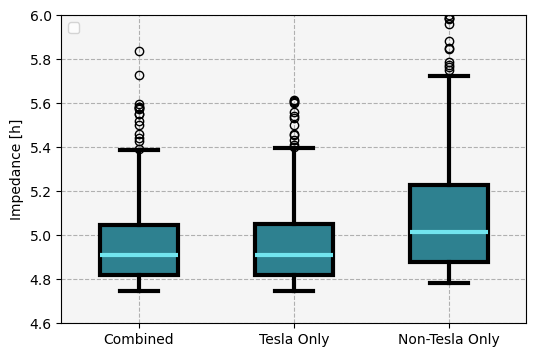

In [32]:
x = [
    df[df['graph_index'] == 0]['impedance_w'],
    df[df['graph_index'] == 1]['impedance_w'],
    df[df['graph_index'] == 2]['impedance_w'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#2e8190',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#72e5ef',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

# kw = {
#     'color': 'k',
#     'lw': 2,
#     'ls': 'dashdot',
#     'label': 'Pacifica Regional Impedance (Total Time)',
# }

# ax.plot([-1, 4], [4.161, 4.161], **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    # 'yticks': np.arange(4, 7.25, .1),
    'xlim': (.5, 3.5),
    'ylim': (4.6, 6),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

# fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Impedance.png', bbox_inches = 'tight', dpi = 300)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


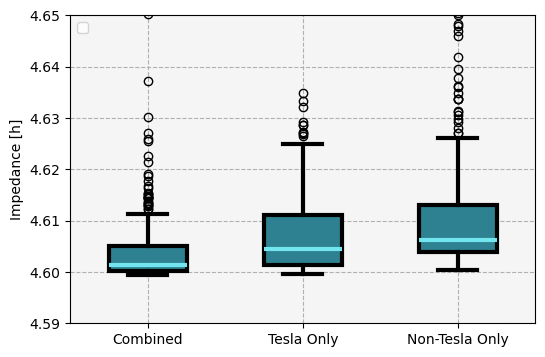

In [38]:
x = [
    df[df['graph_index'] == 0]['impedance_w_d'],
    df[df['graph_index'] == 1]['impedance_w_d'],
    df[df['graph_index'] == 2]['impedance_w_d'],
]

fig, ax = plt.subplots(1, 1, figsize = (6, 4))

kw = {
    # 'notch': True,
    'widths': .5,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#2e8190',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#72e5ef',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

_ = ax.boxplot(x, **kw)

kw = {
    'color': 'k',
    'lw': 2,
    'ls': 'dashdot',
    'label': 'Pacifica Regional Impedance (Driving Time)',
}

# ax.plot([-1, 4], [4.118, 4.118], **kw)

kw = {
    'xticklabels': ['Combined', 'Tesla Only', 'Non-Tesla Only'],
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    # 'yticks': np.arange(4.1, 4.3, .025),
    'xlim': (.5, 3.5),
    'ylim': (4.59, 4.65),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(loc = 2)

# fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Impedance_Driving.png', bbox_inches = 'tight', dpi = 300)

In [201]:
cities_california = src.graph.subgraph(
    cities, [n for n in cities.nodes if '(State Line)' not in n]
)

In [202]:
pacifica_sri = np.array([10.81331175,  9.08769618,  7.56235954,  6.73363645,  5.18683418,
        4.69314255,  5.12188198,  4.88346958,  3.88588944,  3.28200579,
        2.77253372,  4.13586792])

In [113]:
df_sel = df[(df['graph_index'] == 1)]
# df_sel = df
df_sel['risk_attitude_exp'] = np.exp(df_sel['risk_attitude'])

formula = (
    'impedance_w ~ ' +
    # 'C(graph_index) * ' + 
    'capacity * ' + 
    'power * ' + 
    'reliability * ' +
    'risk_attitude'
)


# formula = (
#     'impedance_w ~ ' +
#     'C(graph_index) + ' + 
#     'capacity + ' + 
#     'power + ' + 
#     'reliability + ' +
#     'risk_attitude'
# )

model = smf.ols(formula, data = df_sel).fit()

In [114]:
deep_reload(src)

label_substitutions={
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string=src.analysis.model_anova_tabular(
    model, df_sel, 'impedance_w', 4, c = 3,
)

print(out_string)

4 48
448 47 495
\hline R & R-Squared & Adjusted R-Squared & Std. Error \\
\hline 0.934 & 0.872 & 0.859 & 0.000 \\
\hline
\hline Category & Sum of Squares & DOF & Mean Squares \\
\hline Model & 13.618 & 47 & 0.290 \\
\hline Error & 1.994 & 448 & 0.004 \\
\hline Total & 15.612 & 495 & 0.032 \\
\hline  \multicolumn{2}{|c|}{$F$} &  \multicolumn{2}{c|}{$P(>F)$}  \\
\hline  \multicolumn{2}{|c|}{65.098} &  \multicolumn{2}{c|}{0.000}  \\
\hline
None


In [115]:
deep_reload(src)

label_substitutions = {
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_string = src.analysis.significant_parameters_tabular(
    model, alpha = .1,
    label_substitutions = label_substitutions
)

print(out_string)

\hline {\small Intercept } & 5.522 & 0.000 \\
\hline {\small power } & -0.781 & 0.000 \\
\hline {\small capacity } & -0.871 & 0.000 \\
\hline {\small reliability } & -0.125 & 0.087 \\
\hline {\small capacity:power } & 0.829 & 0.000 \\
\hline {\small power:risk_attitude } & 0.266 & 0.078 \\
\hline {\small capacity:reliability } & 0.303 & 0.022 \\
\hline {\small capacity:risk_attitude } & 0.247 & 0.096 \\
\hline {\small capacity:power:risk_attitude } & -0.549 & 0.038 \\



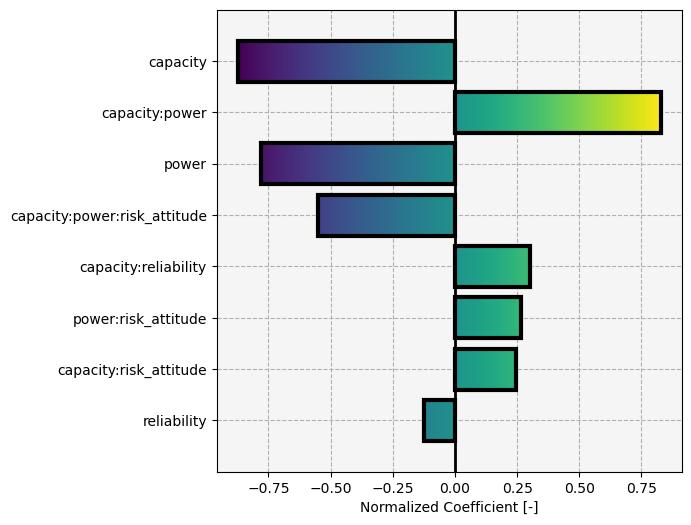

In [116]:
deep_reload(src)

label_substitutions = {
    'C(graph_index)[T.1]': 'Tesla Only',
    'C(graph_index)[T.2]': 'Non-Tesla Only',
    'risk_attitude_low': 'risk_attitude',
}

out_dict = src.analysis.significant_parameters(
    model, alpha = .1,
    label_substitutions = label_substitutions
)

out_dict.pop('Intercept')

for key, val in out_dict.items():

    val['key'] = key

out_list = np.flip(sorted(out_dict.values(), key = lambda x: np.abs(x['coefficient'])))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'ec': 'k',
    'fc': 'none',
    'lw': 3,
    'zorder': 4,
}

vmin = min([v['coefficient'] for v in out_dict.values()])
vmax = max([v['coefficient'] for v in out_dict.values()])

cmap = src.figures.colormap(["#72e5ef", "#2e8190"])
cmap = src.figures.colormap("viridis")

idx = len(out_dict) - 1

for value in out_list:

    c = value['coefficient']

    bounds = ((c - vmin) / (vmax - vmin), (0 - vmin) / (vmax - vmin))
    gradient = np.atleast_2d(np.linspace(bounds[1], bounds[0], 1000))

    bars = ax.barh(idx, width = c, **kw)
    bar = bars[0]
    
    x, y = bar.get_xy()
    w, h = bar.get_width(), bar.get_height()
    ax.imshow(
        gradient,
        cmap = cmap,
        extent=[x, x + w, y , y + h],
        aspect="auto",
        zorder = 3,
        vmin = 0,
        vmax = 1,
    )

    idx -= 1

kw = {
    'color': 'k',
    'lw': 2,
    'ls': '-',
    'zorder': 4,
}

ax.plot([0, 0], [-1, len(out_list)], **kw)

kw = {
    'yticks': list(range(len(out_dict))),
    'xlabel': 'Normalized Coefficient [-]',
    'yticklabels': np.flip([v['key'] for v in out_list]),
    'facecolor': 'whitesmoke',
    'ylim': (-1, len(out_list)),
    'xlim': (1.1 * vmin, 1.1 * vmax),
    # 'xticks': np.arange(-1.7, 1.1, .2),
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)
# 
fig.savefig('Paper/figs/significant_parameters.png', bbox_inches = 'tight', dpi = 300)

In [124]:
stations_used_sng = {
    0: {},
    1: {},
    2: {},
}

for idx, values in paths.items():

    path_collection = values['paths']
    sng = values['sng']

    for path_col in path_collection.values():

        for path in path_col.values():

            for p in path:

                if p in stations_used_sng[sng]:

                    stations_used_sng[sng][p] += 1

                else:

                    stations_used_sng[sng][p] = 1

In [60]:
stations_used = {}

graph_index = df['graph_index'].to_numpy()

for idx, values in paths.items():

    path_collection = values['paths']

    for path_col in path_collection.values():

        for path in path_col.values():

            for p in path:

                if p in stations_used:

                    stations_used[p] += 1

                else:

                    stations_used[p] = 1

In [127]:
len(stations_used_sng[0]), len(stations_used_sng[1]), len(stations_used_sng[2])

(456, 198, 364)

In [128]:
graph = src.graph.graph_from_json('Outputs/sng_combined.json')
nodes = graph._node

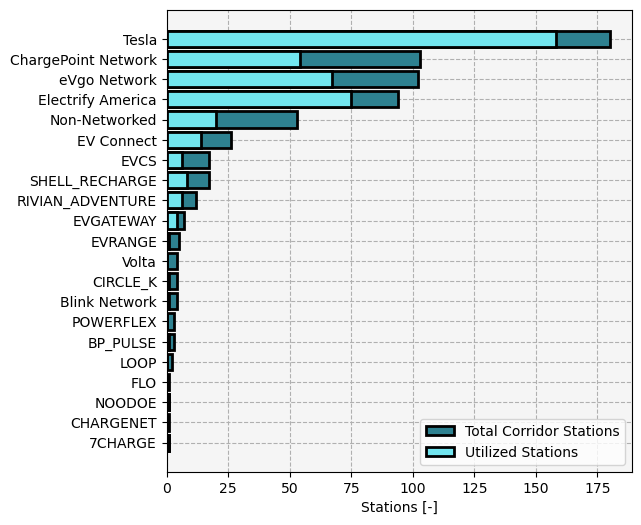

In [166]:
nodes = graph._node

stations_used = stations_used_sng[0]

networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

ung, ungc = np.unique(networks_general, return_counts = True)
un, unc = np.unique(network, return_counts = True)

indices = np.argsort(ungc)

utilization = {}

for idx in indices:

    utilization[ung[idx]] = {'total': ungc[idx], 'utilized': sum(unc[un == ung[idx]])}

x = np.array(list(range(len(ungc))))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': '#2e8190',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Corridor Stations'
}

ax.barh(x, [v['total'] for v in utilization.values()], **kw)


kw = {
    'color': '#72e5ef',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, [v['utilized'] for v in utilization.values()], **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': ung[indices],
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

kw = {
    'loc': 4,
}

_ = ax.legend(**kw)

# fig.savefig('Paper/figs/corridor_station_utilization.png', bbox_inches = 'tight', dpi = 300)

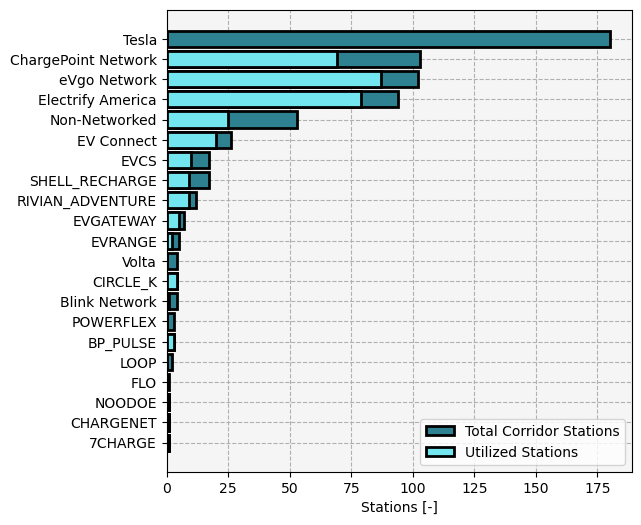

In [165]:
nodes = graph._node

stations_used = stations_used_sng[2]

networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

ung, ungc = np.unique(networks_general, return_counts = True)
un, unc = np.unique(network, return_counts = True)

indices = np.argsort(ungc)

utilization = {}

for idx in indices:

    utilization[ung[idx]] = {'total': ungc[idx], 'utilized': sum(unc[un == ung[idx]])}

x = np.array(list(range(len(ungc))))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': '#2e8190',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Corridor Stations'
}

ax.barh(x, [v['total'] for v in utilization.values()], **kw)


kw = {
    'color': '#72e5ef',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, [v['utilized'] for v in utilization.values()], **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': ung[indices],
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

kw = {
    'loc': 4,
}

_ = ax.legend(**kw)

# fig.savefig('Paper/figs/corridor_station_utilization.png', bbox_inches = 'tight', dpi = 300)

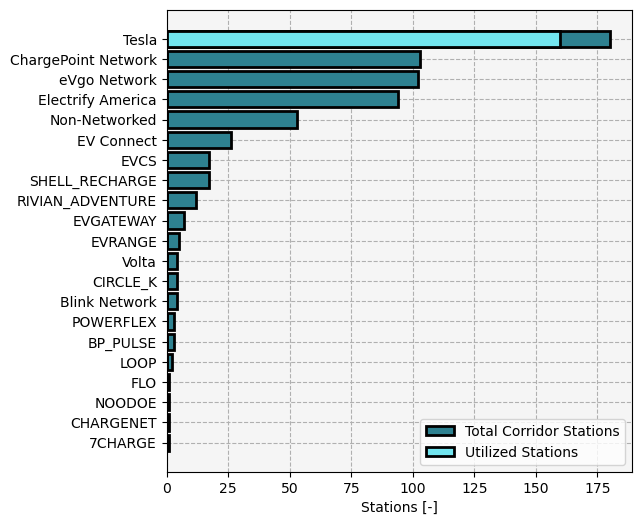

In [167]:
nodes = graph._node

stations_used = stations_used_sng[1]

networks_general = [v['network'] for k, v in nodes.items() if 'station' in k]
network = [nodes[k]['network'] for k, v in stations_used.items() if 'station' in k]

ung, ungc = np.unique(networks_general, return_counts = True)
un, unc = np.unique(network, return_counts = True)

indices = np.argsort(ungc)

utilization = {}

for idx in indices:

    utilization[ung[idx]] = {'total': ungc[idx], 'utilized': sum(unc[un == ung[idx]])}

x = np.array(list(range(len(ungc))))

fig, ax = plt.subplots(1, 1, figsize = (6, 6))

kw = {
    'color': '#2e8190',
    'ec': 'k',
    'lw': 2,
    'zorder': 3,
    'label': 'Total Corridor Stations'
}

ax.barh(x, [v['total'] for v in utilization.values()], **kw)


kw = {
    'color': '#72e5ef',
    'ec': 'k',
    'lw': 2,
    'zorder': 4,
    'label': 'Utilized Stations'
}

ax.barh(x, [v['utilized'] for v in utilization.values()], **kw)

kw = {
    'xlabel': 'Stations [-]',
    'yticks': x,
    'yticklabels': ung[indices],
    'facecolor': 'whitesmoke',
}

_ = ax.set(**kw)

kw = {
    'ls': 'dashed',
    'zorder': 3,
}

_ = ax.grid(**kw)

kw = {
    'loc': 4,
}

_ = ax.legend(**kw)

# fig.savefig('Paper/figs/corridor_station_utilization.png', bbox_inches = 'tight', dpi = 300)

In [67]:
graph_empty = src.graph.graph_from_json('Outputs/graph_empty.json')

In [68]:
outline = gpd.read_file('Data/State/tl_2023_us_state.shp')

In [69]:
atlas = src.graph.graph_from_json('atlas.json')

In [70]:
utilized = [k for k, v in stations_used.items() if 'station' in k]

sng_utilized = src.graph.subgraph(graph, utilized)

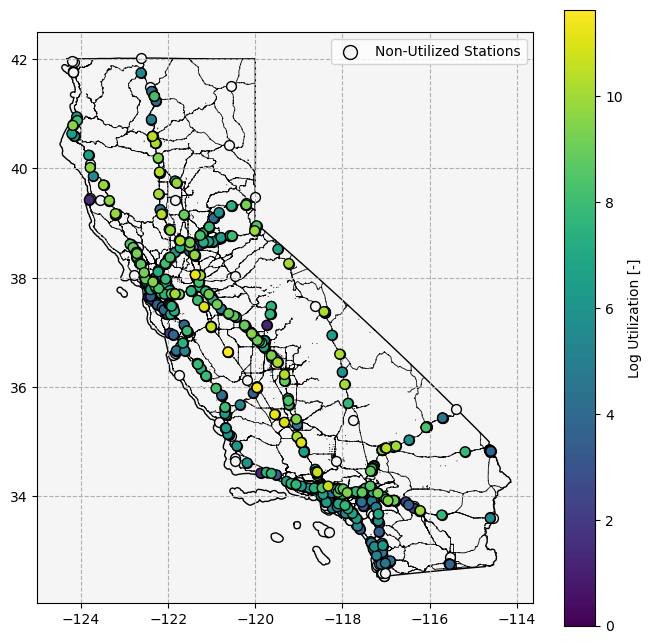

In [71]:
for source, node in sng_utilized._node.items():

    node['n_utilized'] = np.log(stations_used[source])

fig, ax = plt.subplots(figsize = (8, 8))

outline[outline['STATEFP'] == '06'].plot(ax = ax, fc = 'none', ec = 'k')

kw = {
    'show_links': False,
    'scatter': {
        's': .5,
        'ec': 'none',
        'fc': 'k',
        'zorder': 0,
    },
}

src.figures.plot_graph(atlas, ax = ax, **kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 300,
        'ec': 'k',
        'fc': '#ffd601',
        'zorder': 4,
        'label': 'Selected Locations',
    },
}

kw = {
    'facecolor': 'whitesmoke',
}

ax.set(**kw)

kw = {
    'ls': 'dashed',
}

ax.grid(**kw)

kw = {
    'show_links': False,
    'scatter': {
        's': 50,
        'ec': 'k',
        'fc': 'whitesmoke',
        'zorder': 1,
        'label': 'Non-Utilized Stations',
    },
}

# src.figures.plot_graph(graph_empty, ax = ax, **kw)
src.figures.plot_graph(graph, ax = ax, **kw)

kw = {
    'show_links': False,
    'node_field': 'n_utilized',
    'scatter': {
        's': 50,
        'ec': 'k',
        # 'fc': '#72e5ef',
        'zorder': 2,
        # 'label': 'Utilized Stations',
    },
    'colorbar': {
        'label': 'Log Utilization [-]',
        # 'ticks': list(range(1, 6)),
    },
}

src.figures.plot_graph(sng_utilized, ax = ax, **kw)

kw = {
    'fontsize': 'medium',
}
    

legend = ax.legend(**kw)

for h in legend.legendHandles:
    h._sizes = [100]
    

# fig.savefig('Paper/figs/California_SNG_Utilization.png', bbox_inches = 'tight', dpi = 300)

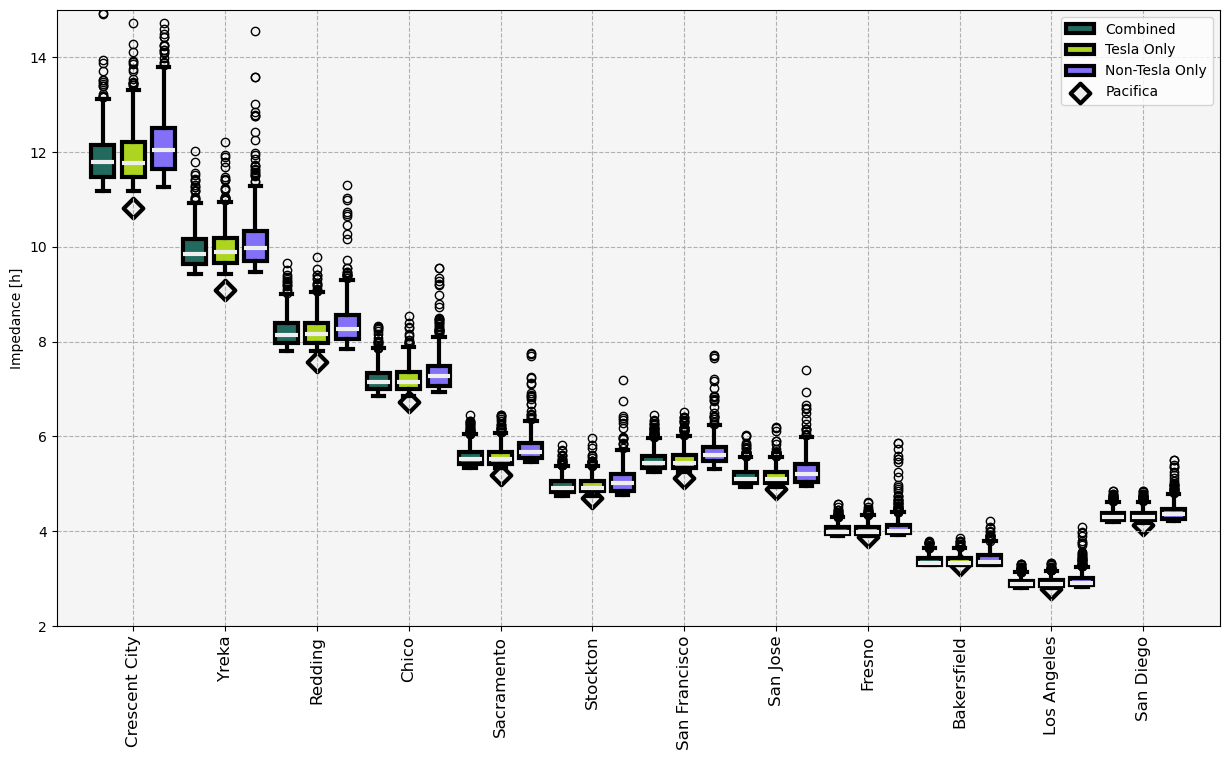

In [203]:
x0 = [df[df['graph_index'] == 0][k] for k in cities_california.nodes]
x1 = [df[df['graph_index'] == 1][k] for k in cities_california.nodes]
x2 = [df[df['graph_index'] == 2][k] for k in cities_california.nodes]

fig, ax = plt.subplots(1, 1, figsize = (15, 8))

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#22695e',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp0 = ax.boxplot(x0, positions = np.arange(0, 12, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#add51f',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp1 = ax.boxplot(x1, positions = np.arange(.33, 12.33, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#8270f6',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp2 = ax.boxplot(x2, positions = np.arange(.66, 12.66, 1), **kw)

kw = {
    'ec': 'k',
    'fc': '#eeeeee',
    'marker': 'D',
    'lw': 3,
    's': 100,
    'label': 'Pacifica',
}

sc0 = ax.scatter(np.arange(.33, 12.33, 1), pacifica_sri, **kw)

kw = {
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    'ylim': (2, 15),
}

_ = ax.set(**kw)

_ = ax.set_xticks(np.arange(.33, 12.33, 1))
_ = ax.set_xticklabels(list(cities_california.nodes), rotation = 90, fontsize = 12)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], sc0],
    ['Combined', 'Tesla Only', 'Non-Tesla Only', 'Pacifica'],
    loc = 'upper right',
)

fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Specific_Impedance_1.png', bbox_inches = 'tight', dpi = 300)

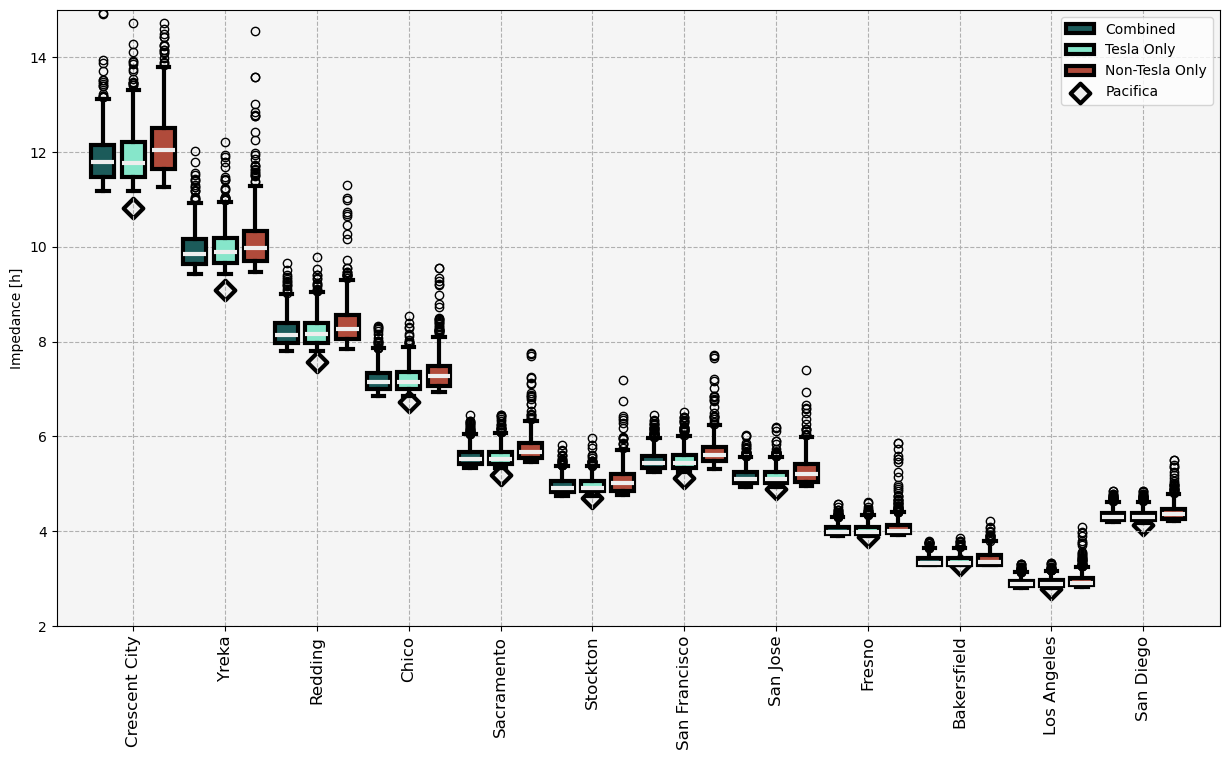

In [204]:
x0 = [df[df['graph_index'] == 0][k] for k in cities_california.nodes]
x1 = [df[df['graph_index'] == 1][k] for k in cities_california.nodes]
x2 = [df[df['graph_index'] == 2][k] for k in cities_california.nodes]

fig, ax = plt.subplots(1, 1, figsize = (15, 8))

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#1c5b5a',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp0 = ax.boxplot(x0, positions = np.arange(0, 12, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#86e6ca',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp1 = ax.boxplot(x1, positions = np.arange(.33, 12.33, 1), **kw)

kw = {
    'widths': .25,
    'zorder': 3,
    'patch_artist': True,
    'boxprops': {
        'fc': '#b04b3b',
        'ec': 'k',
        'lw': 3,
    },
    'medianprops': {
        'color': '#eeeeee',
        'lw': 3,
    },
    'whiskerprops': {
        'lw': 3,
        'color': '#000000',
    },
    'capprops': {
        'lw': 3,
        'color': '#000000',
    },
}

bp2 = ax.boxplot(x2, positions = np.arange(.66, 12.66, 1), **kw)

kw = {
    'ec': 'k',
    'fc': '#eeeeee',
    'marker': 'D',
    'lw': 3,
    's': 100,
    'label': 'Pacifica',
}

sc0 = ax.scatter(np.arange(.33, 12.33, 1), pacifica_sri, **kw)

kw = {
    'facecolor': 'whitesmoke',
    'ylabel': 'Impedance [h]',
    'ylim': (2, 15),
}

_ = ax.set(**kw)

_ = ax.set_xticks(np.arange(.33, 12.33, 1))
_ = ax.set_xticklabels(list(cities_california.nodes), rotation = 90, fontsize = 12)

kw = {
    'ls': 'dashed',
    'zorder': 0,
}

_ = ax.grid(**kw)

_ = ax.legend(
    [bp0["boxes"][0], bp1["boxes"][0], bp2["boxes"][0], sc0],
    ['Combined', 'Tesla Only', 'Non-Tesla Only', 'Pacifica'],
    loc = 'upper right',
)

fig.savefig('Paper/figs/Networks_Boxplots_Weighted_Specific_Impedance_2.png', bbox_inches = 'tight', dpi = 300)